<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

#  Intro to MPI (point-to-point)

## Contents


In this notebook, we will learn the basics of parallel computing using the Message Passing Interface (MPI) from Julia. In particular, we will learn:

- How to use point-to-point communication directives
- Which are the pros and cons of several types of send and receive functions
- Which are the common pitfalls when using point-to-point directives



## What is MPI ?

- MPI stands for the "Message Passing Interface"
- It is a standardized library specification for communication between parallel processes in distributed-memory systems.
- It is the gold-standard for distributed computing in HPC systems since the 90s
- It is huge: the MPI standard has more than 1k pages (see https://www.mpi-forum.org/docs/mpi-4.0/mpi40-report.pdf)
- There are several implementations of this standard (OpenMPI, MPICH, IntelMPI)
- The interface is in C and FORTRAN (C++ was deprecated)
- There are Julia bindings via the package MPI.jl https://github.com/JuliaParallel/MPI.jl

### Before starting this notebook

Read this paper to get an overview of the history and rationale behind MPI:

J.J. Dongarra, S.W. Otto, M. Snir, and D. Walker, David. A message passing standard for MPP and workstations, *Commun. ACM*, 39(7), 84–90, 1996. DOI: [10.1145/233977.234000](https://doi.org/10.1145/233977.234000).



### What is MPI.jl ?

We will access MPI via the Julia bindings provided by the [`MPI.jl`]( https://github.com/JuliaParallel/MPI.jl) package. It is worth noting that:

- MPI is not a Julia implementation of the MPI standard
- It is just a wrapper to the C interface of MPI.
- You need a C MPI installation in your system (MPI.jl downloads one for you when needed).


### Why MPI.jl?

MPI.jl provides a convenient Julia API to access MPI. For instance, this is how you get the id (rank) of the current process.

```julia
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
```

Internally, MPI.jl uses `ccall` which is a mechanism that allows you to call C functions from Julia. In this, example we are calling the C function `MPI_Comm_rank` from the underlying MPI installation.

```julia
comm = MPI.COMM_WORLD    
rank_ref = Ref{Cint}()
ccall((:MPI_Comm_rank, MPI.API.libmpi), Cint, (MPI.API.MPI_Comm, Ptr{Cint}), comm, rank_ref)
rank = Int(rank_ref[])
```



If you are curious, run next cell to get more information about how `ccall` works.

In [ ]:
? ccall

### Installing MPI in Julia

MPI can be installed as any other Julia package using the package manager.

In [ ]:
] add MPI

<div class="alert alert-block alert-info">
<b>Note:</b> Julia will download and install a MPI library for you, but it is also possible to use a MPI library already available in your system. This is useful, e.g., when running on HPC clusters. See the documentation of MPI.jl for further details. See more information in <a href="https://github.com/JuliaParallel/MPI.jl">https://github.com/JuliaParallel/MPI.jl</a>
</div>

## Minimal MPI program

An MPI program must, at least, initialize and then finalize MPI. Finalizing MPI in the user code is optional in Julia as there is an internal mechanism that will finalize MPI for your. You can deactivate this mechanism by initializing MPI with `MPI.Init(finalize_atexit=false)`. Once finalized, MPI procedures cannot be used anymore except very few exceptions.


In Julia (option 1, recommended):

```julia
using MPI
MPI.Init()
# Your MPI programm here
MPI.Finalize() # Optional
```

In Julia (option 2, advanced):

```julia
using MPI
MPI.Init(finalize_atexit=false)
# Your MPI programm here
MPI.Finalize() # Mandatory
```

In C:

```C
#include <mpi.h>
int main(int argc, char** argv) {
    MPI_Init(NULL, NULL);
    /* Your MPI Programm here */
    MPI_Finalize();
}
```

<div class="alert alert-block alert-info">
<b>Note:</b> Note that the Julia syntax is almost 1-to-1 to the C one. The key difference is that in Julia MPI routines are written as `MPI.X` where in C are written `MPI_X`.
</div>

### An incorrect MPI program

It is very easy to end up with incorrect programs when using MPI if you are not careful following the rules. In this notebook, we will see many examples. For instance:

```julia
using MPI
MPI.Init(;finalize_atexit=false)
@assert rand(1:10) != 2
MPI.Finalize()
```

In some process `rand(1:10)` might be 2 and the program will stop without reaching `MPI.Finalize()` leading to an incorrect program.

### Solving the issue

Premature finalization of a program is done with `MPI_Abort`.

```julia
using MPI
MPI.Init()
if rand(1:10) != 2
    errorcode = -1
    MPI.Abort(MPI.COMM_WORLD,errorcode)
end
MPI.Finalize()
```

There is no need to call `MPI_Abort` in all ranks. The MPI library will do its best to stop all MPI ranks even if `MPI_Abort` was called just on a single rank.

<div class="alert alert-block alert-info">
<b>Note:</b> Processes are often called ranks, when working with MPI.
</div>

### Read the docs

Not sure if an MPI routine needs to be called by all ranks? Read the documentation, specially the external links. Run the next cell, open an external link and read the documentation.

In [ ]:
? MPI.Finalize

## Basic information about MPI processes

The following cells give information about MPI processes, such as the rank id, the total number of processes and the name of the host running the code. Before calling this functions one needs to initialize MPI.

In [ ]:
using MPI
MPI.Init()

<div class="alert alert-block alert-info">
<b>Note:</b> If you get some error or warning when initializing MPI, make sure that you started the notebook using `IJulia`. Go back to the first notebook for specific details.
</div>

 Current rank (process) id

In [ ]:
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)

<div class="alert alert-block alert-info">
<b>Note:</b> Note that the rank ids start with 0.
</div>

Number of available processes

In [ ]:
nranks = MPI.Comm_size(comm)

Name of the current host

In [ ]:
MPI.Get_processor_name()

Note that this note notebook is running on a single process. So using MPI will only make sense later when we add more processes.

### Hello-world example

Using these functions we can create the a classic MPI hello world example. This example (or variations thereof) are used in practice to check how MPI ranks are mapped to available processing units in a given computing system.


In [ ]:
using MPI
MPI.Init()
comm = MPI.COMM_WORLD
nranks = MPI.Comm_size(comm)
rank = MPI.Comm_rank(comm)
host = MPI.Get_processor_name()
println("Hello from $host, I am process $rank of $nranks processes!")

### Hello world in C

This is the equivalent code in C.

```C
#include <mpi.h>
#include <stdio.h>
int main(int argc, char** argv) {
    MPI_Init(NULL, NULL);
    int world_size;
    MPI_Comm_size(MPI_COMM_WORLD, &world_size);
    int world_rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &world_rank);
    char processor_name[MPI_MAX_PROCESSOR_NAME];
    int name_len;
    MPI_Get_processor_name(processor_name, &name_len);
    printf("Hello from %s, I am rank %d of %d ranks!\n",
           processor_name, world_rank, world_size);
    MPI_Finalize();
}
```

## Running MPI code

### Creating MPI processes (aka ranks)

MPI processes are created with the driver program `mpiexec`, which comes as part of an MPI installation:

- `mpiexec` takes an application as argument, it creates different processes, and runs the application on these processes.
- The application will typically call MPI directives to communicate between these ranks
- In particular, the application can be `julia code.jl`, i.e., Julia running a given script `code.jl`.


 <div>
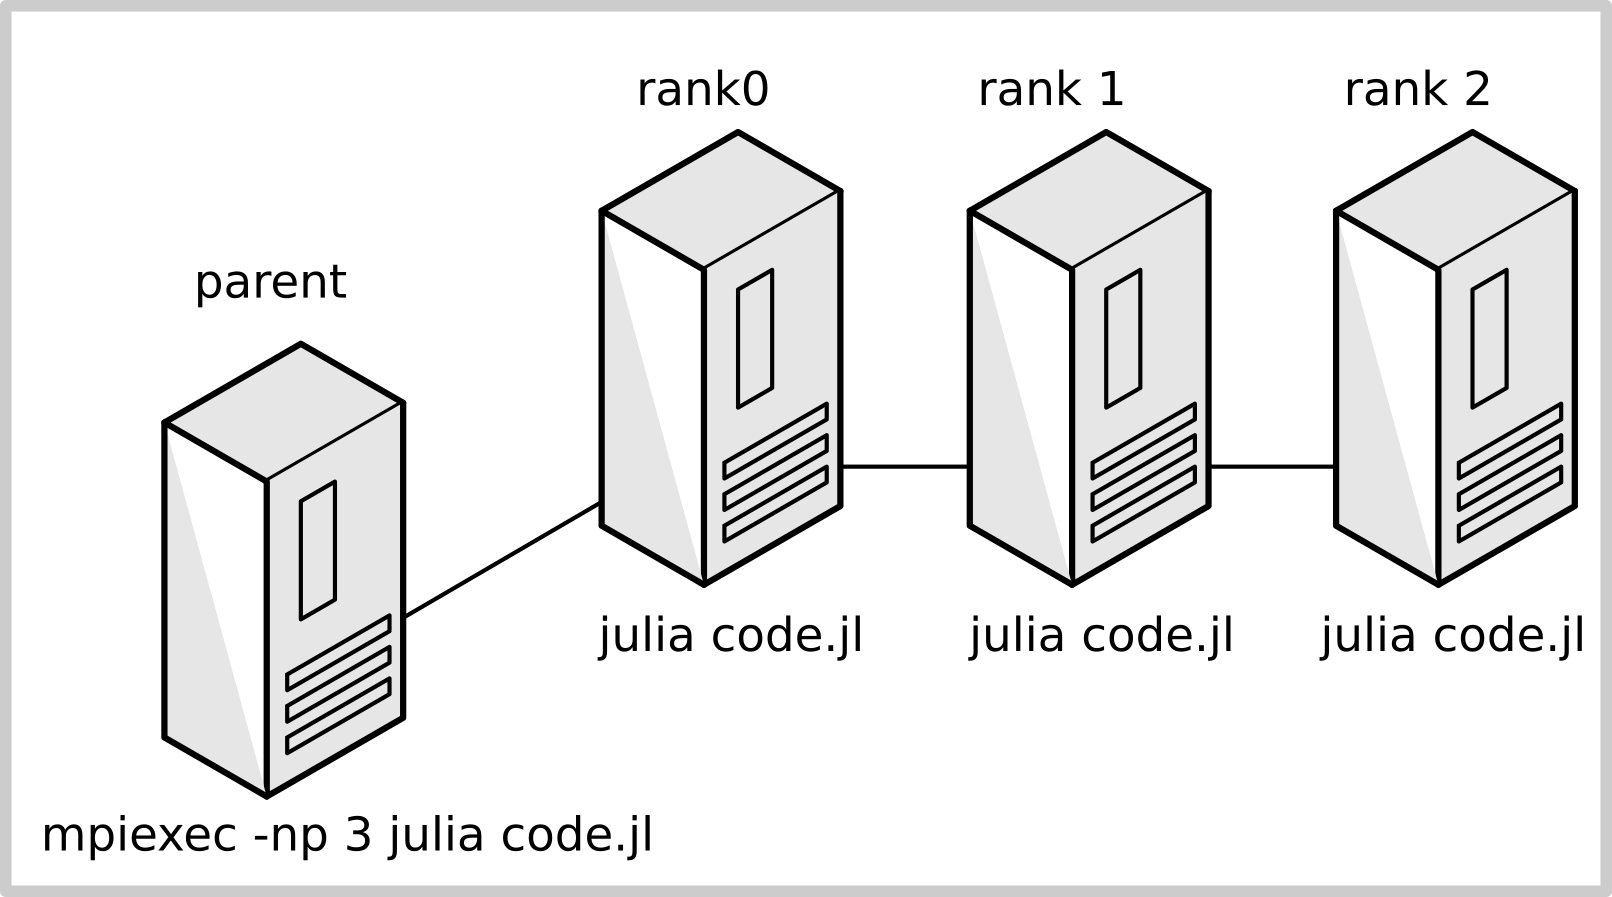
</div>
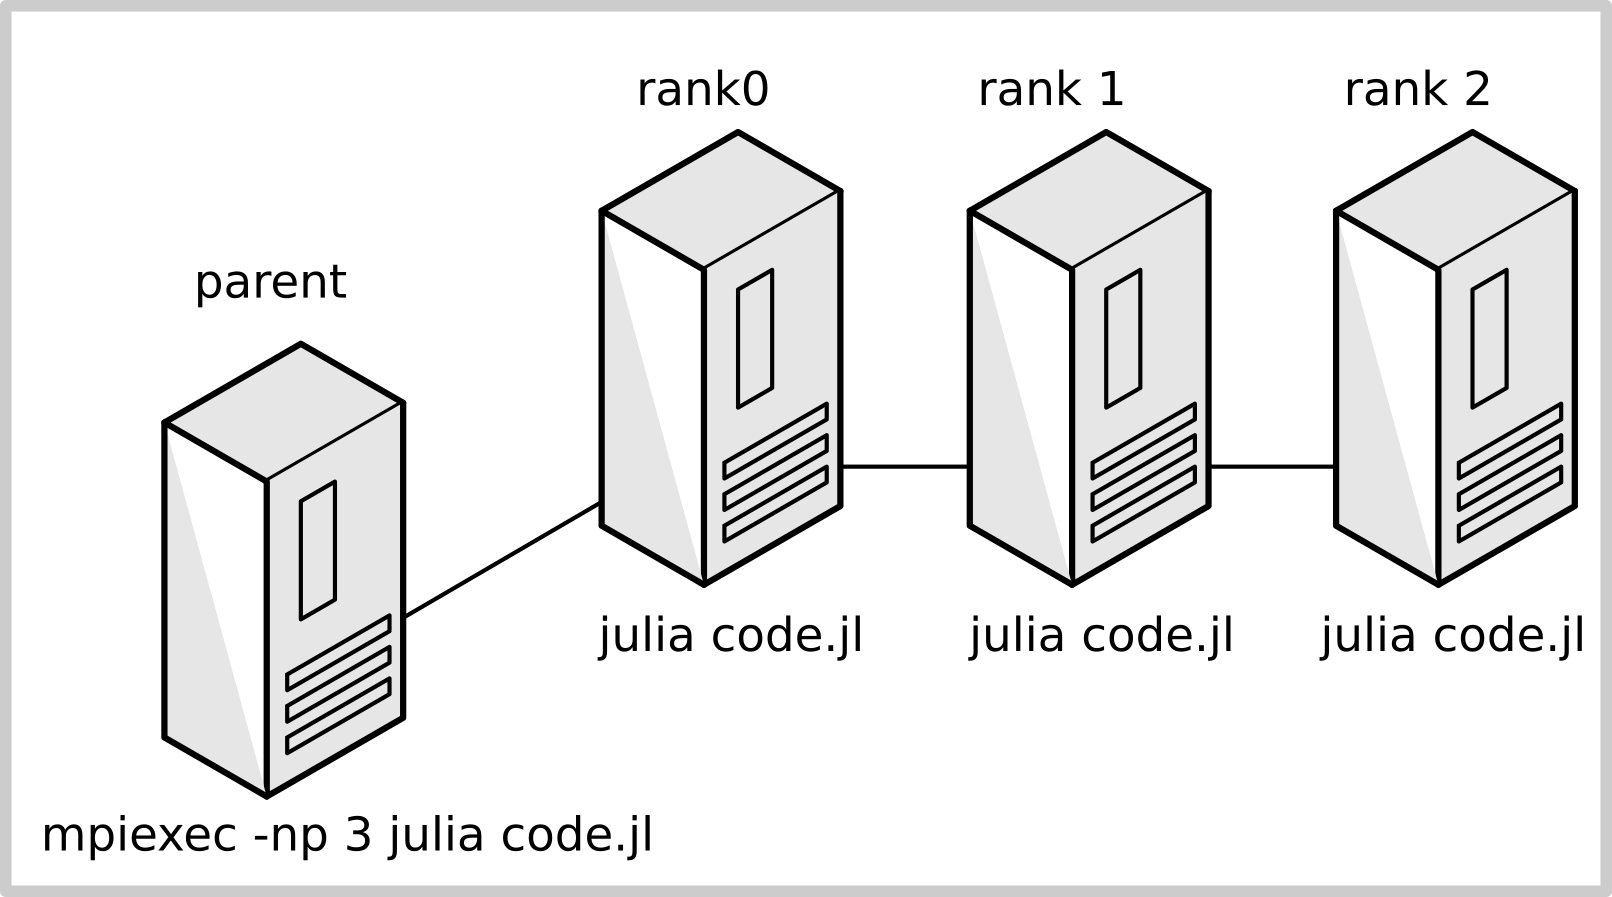

### Execution model

- MPI programs are typically run with a Single Program Multiple Data (SPMD) model, which is a particular case of the SIMD model.
- But the standard supports Multiple Program Multiple Data (MPMD), which is a particular case of the MIMD model.

### Hello world example

Julia code typically needs to be in a file to run it in with MPI. Let's us write our hello world in a file. The next cell will create a file, and write some code in it.

In [ ]:
code = raw"""
using MPI
MPI.Init()
comm = MPI.COMM_WORLD
nranks = MPI.Comm_size(comm)
rank = MPI.Comm_rank(comm)
println("Hello, I am process $rank of $nranks processes!")
MPI.Finalize()
"""
filename = tempname()*".jl"
write(filename,code)
filename

Now, we can run it

In [ ]:
using MPI
run(`$(mpiexec()) -np 4 julia --project=. $filename`);

<div class="alert alert-block alert-info">
<b>Note:</b> Function `mpiexec` provided by `MPI.jl` is a convenient way of accessing the `mpiexec` program that matches the MPI installation used by Julia.
</div>

### Another way to launch MPI code

In the hello world example above we have created an auxiliary file to run the code with MPI. This can be annoying specially if you are working in a jupyter notebook. With this other syntax you can skip creating the auxiliary file. We use `quote` which is part of the [meta-programming capabilities of Julia](https://docs.julialang.org/en/v1/manual/metaprogramming/). 

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    println("Hello, I am process $rank of $nranks processes!")
    MPI.Finalize()
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## Data availability

Note that mpiexec creates new processes which are different from the process running this notebook. In particular, these new processes will not see any variables or function definitions in the current notebook. So, the full MPI program needs to be in the source file passed to Julia or the quote block.

The following cell will fail. Note that the same error message is displayed by all ranks, which makes difficult to read them.

In [ ]:
foo() = print("Hi there!")
code = quote
    using MPI
    MPI.Init()
    foo()
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

So, the full MPI program needs to be in the source file passed to Julia or the quote block. In practice, long MPI programms are written as Julia packages using several files, which are then loaded by each MPI process. For our simple example, we just need to include the definition of `foo` inside the quote block.

In [ ]:
code = quote
    foo() = print("Hi there!")
    using MPI
    MPI.Init()
    foo()
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## Point-to-point communication

Now we are up and running, and ready to start learning MPI communication primitives. In this notebook we will cover so-called point-to-point communication directives. In a later notebook we will also learn about collective primitives.

MPI  provides point-to-point communication directives for arbitrary communication between processes. Point-to-point communications are two-sided: there is a sender and a receiver. Here, we will discuss different types of directives:

- `MPI_Send`, and `MPI_Recv` (*blocking directives*)
- `MPI_Isend`, and `MPI_Irecv` (*non-blocking directives*)
- `MPI_Bsend`, `MPI_Ssend`, and `MPI_Rsend` (*advanced communication modes*)

In all cases, these functions are used to send a message from a ranks and receive it in another rank. See next picture.

<div>
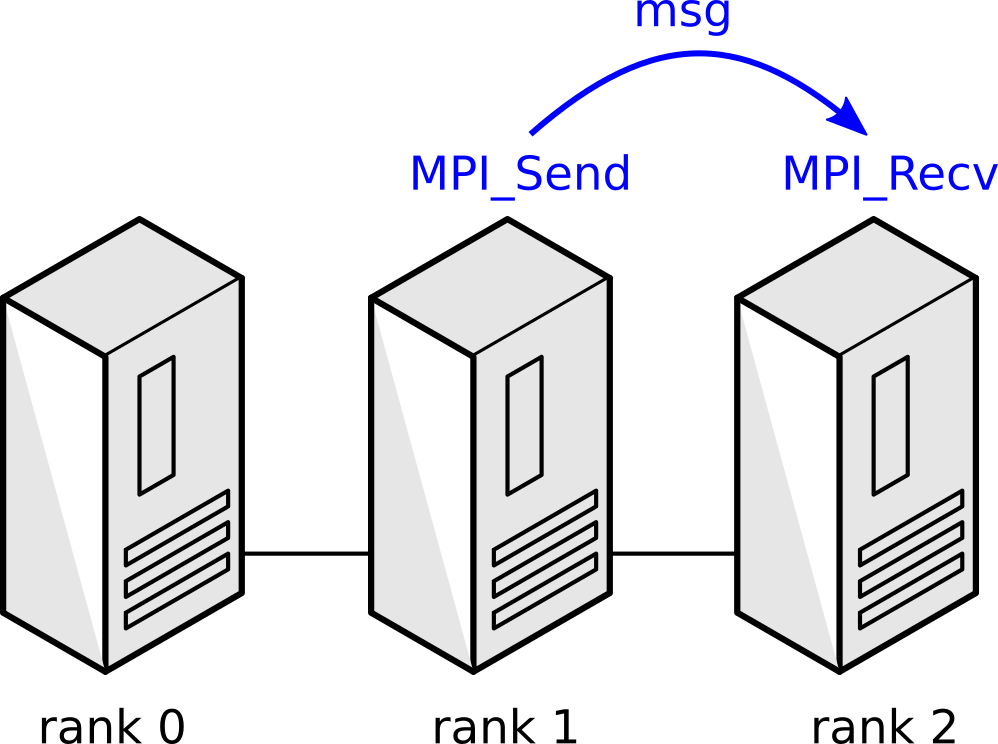
</div>
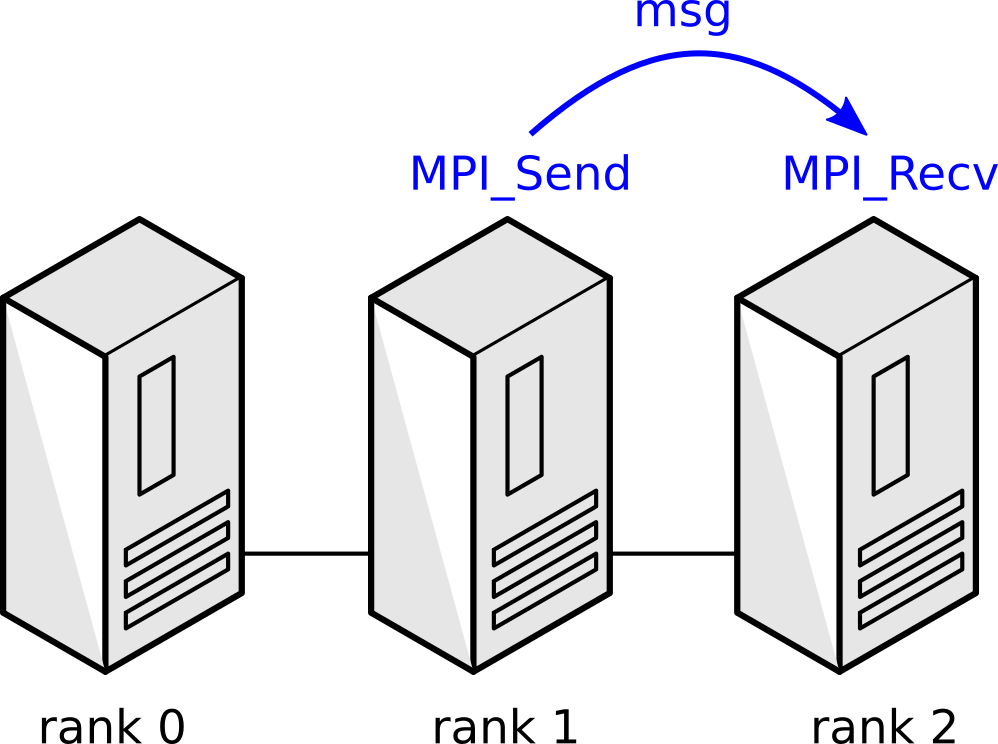

## Blocking send and receive

Let's start with the "standard" blocking send and receive.

In Julia:

```julia
MPI.Send(sndbuf, comm; dest, tag)
_, status = MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
```
In C:
```C
int MPI_Send(const void *sndbuf, int count, MPI_Datatype datatype, int dest,
    int tag, MPI_Comm comm)
int MPI_Recv(void *rcvbuf, int count, MPI_Datatype datatype,
    int source, int tag, MPI_Comm comm, MPI_Status *status)
```

The key arguments are:

* `sndbuf` data to send.
* `rcvbuf` space to store the incoming data.
* `source` rank of the sender.
* `dest` rank of the receiver.
* `tag`. Might be used to distinguish between different kinds of messages from the same sender to the same receiver (similar to the "subject" in an email).


<div class="alert alert-block alert-info">
<b>Note:</b> Note that the C interface provides additional arguments `MPI_Datatype` (type of data to send/receive) and `count` (number of items to send/receive). In Julia, send and receive buffers are usually arrays or references, from which the data type and the count can be inferred. This is true for many other MPI functions.
</div>

### Example

Send 5 integers from rank 2 to rank 3. Note that the same code will be executed in all ranks by `mpiexec`. This is why we need to use if statements to select specific ranks.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        rcvbuf = zeros(Int,5) # Allocate space for the incoming message
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=2, tag=0)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## Any source, any tag

We can use

* `source = MPI.ANY_SOURCE`
* `tag = MPI.ANY_TAG`

If we want to receive messages from any source and/or with any tag.


<div class="alert alert-block alert-info">
<b>Note:</b> These can only be used by the receiver, not the sender. Moreover there is no option to send to any destination.
</div>


### Example

Send 5 integers from rank 2 to rank 3. Since there is only one sender and only one message from this sender, we can receive from any source and with any tag.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        source = MPI.ANY_SOURCE
        tag = MPI.ANY_TAG
        MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## MPI_Status

When using `MPI.ANY_SOURCE` and `MPI.ANY_TAG` it might be still useful to know which was the sender and which tag was used. This information is given by a `MPI.Status` object.


```julia
_, status = MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
status.source # Gives the source
status.tag # Gives the tag
```




### Example

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        source = MPI.ANY_SOURCE
        tag = MPI.ANY_TAG
        _, status = MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
        @show rcvbuf
        @show status.source
        @show status.tag
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## MPI_Probe

Note that we need to provide a receive buffer with the right size, but it general we do not know which is the size of the incoming message. This can be solved using an `MPI_Probe`. It works similar to `MPI_Recv`, but instead of receiving the message only receives information about the message (source, tag, and also message size). Like for `MPI_Recv`, `MPI_Probe` will wait (block) until a matching send is posted. More information about the blocking behavior will be given below.


`MPI_Probe` provides an `MPI_Status` object. We can get the message size from the status object using function `MPI_Get_count`. We can also get the source and tag from the status object as shown before.

In Julia:
```julia
status = MPI.Probe(comm,MPI.Status; source, tag)
count = MPI.Get_count(status, T)
```
In C:
```C
int MPI_Probe(int source, int tag, MPI_Comm comm, MPI_Status *status)
int MPI_Get_count(const MPI_Status *status, MPI_Datatype datatype, int *count)
```



### Example

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        source = MPI.ANY_SOURCE
        tag = MPI.ANY_TAG
        status = MPI.Probe(comm,MPI.Status; source, tag)
        count = MPI.Get_count(status,Int) # Get incomming message length
        println("I am about to receive $count integers.")
        rcvbuf = zeros(Int,count) # Allocate        
        MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## Complete operations

Functions `MPI_Send`, `MPI_Recv`, and `MPI_Probe` are *complete* operations, meaning that their argument can be used once the function returns.

In particular:

- It is safe to re-write the send buffer with new data once `MPI_Send` returns.
- The received message is guaranteed to be fully available in the receive buffer once `MPI_Recv` returns.

### Example

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
        sndbuf .= 0 # This is fine. Send has returned.
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=2, tag=0)
        # recvbuf will have the incomming message fore sure. Recv! has returned.
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## Blocking operations

`MPI_Recv` and `MPI_Probe` are *blocking* operations. This means that they will wait for a matching send.



`MPI_Send` is also often called a blocking send, but this is very misleading. `MPI_Send` might or not wait for a matching `MPI_Recv`. Assuming that `MPI_Send` will block waiting for a matching receive is erroneous. I.e., we cannot assume that `MPI_Send` has synchronization side effects with the receiver process. However, assuming that `MPI_Send` will not block is also erroneous. Look into the following example (which in fact is an incorrect MPI program). In contrast, `MPI_Send` guarantees that the send buffer can be reused when function returns (complete operation).

### Incorrect program

The following program will or will not work depending on the underlying implementation and other factors (i.e. this program has undefined behavior). On my laptop, it works with `n=1`, but leads to a dead lock when `n=10000`.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    n = 1
    sndbuf = fill(rank,n)
    rcvbuf = zeros(Int,n)
    if rank == 2
        MPI.Send(sndbuf, comm; dest=3, tag=0)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=3, tag=0)
    end
    if rank == 3
        MPI.Send(sndbuf, comm; dest=2, tag=0)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=2, tag=0)
    end
    @show (rcvbuf[1],rank)
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

<div class="alert alert-block alert-info">
<b>Tip:</b> You can stop the cell from runnig with Kernel > Interrupt. You might need to click in Interrupt 2 times.
</div>

## To buffer or not to buffer outbound messages?

There are two key competing requirements that face implementations of `MPI_Send`.

1. One might want to minimize synchronization time. This is often achieved by copying the outgoing message in an internal buffer and returning from the `MPI_Send` as soon as possible, without waiting for a matching `MPI_Recv`.
2. One might want to avoid data copies (e.g. for large messages). In this case, one needs to wait for a matching receive and return from the `MPI_Send` when the data has been sent.

Thus, there is a trade-off between memory copied (buffering) and synchronization (wait) time. One cannot minimize both at the same time.

## Fixing cyclic dependencies

Returning to the incorrect program seen before. Remember that on my laptop it worked for `n=1`, but it failed for `n=10000`.  For `n=1` the MPI implementation provably decided that the best trade-off was to buffer the small message and return from the `MPI_Send` as soon as possible. For the large message (`n=10000`) it provably decided to wait for a matching receive in order to avoid copying data. In this case, both ranks were  blocked on the call to `MPI_Send` and the receives were never posted leading to a dead lock.

We can fix these cyclic dependences by smartly ordering the sends and the receives:

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    n = 10000
    sndbuf = fill(rank,n)
    rcvbuf = zeros(Int,n)
    if rank == 2
        # We first send and then receive
        MPI.Send(sndbuf, comm; dest=3, tag=0)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=3, tag=0)
    end
    if rank == 3
        # We first receive and then send
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=2, tag=0)
        MPI.Send(sndbuf, comm; dest=2, tag=0)
    end
    @show (rcvbuf[1],rank)
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

Another solution is to use `MPI_Sendrecv`, which will handle the ordering for us.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    n = 10000
    sndbuf = fill(rank,n)
    rcvbuf = zeros(Int,n)
    if rank == 2
        MPI.Sendrecv!(sndbuf,rcvbuf, comm;dest=3,source=3,sendtag=0,recvtag=0)
    end
    if rank == 3
        MPI.Sendrecv!(sndbuf,rcvbuf, comm;dest=2,source=2,sendtag=0,recvtag=0)
    end
    @show (rcvbuf[1],rank)
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## Communication modes

What if we as users want to decide when to buffer a message or when to avoid data copies? This is provided by so-called *communication* modes. There are four modes: standard, buffered, synchronous, and ready provided by the respective functions `MPI_Send`, `MPI_Bsend`, `MPI_Ssend`, and `MPI_Rsend`, respectively. 


All these MPI functions are *complete* MPI operations, and therefore, it is safe to re-write the send buffer once the corresponding send returns. All these send types are matched with an `MPI_Recv`. I.e., there is no `MPI_Brecv`, `MPI_Srecv`, `MPI_Rrecv`. 

 
<div class="alert alert-block alert-info">
<b>Note:</b>  `MPI_Bsend`, `MPI_Ssend`, and `MPI_Rsend` are not exposed in the Julia bindings via a high-level interface like for `MPI.Send`, but they can be accessed using the low-level bindings in the submodule `MPI.API` (not shown in this notebook).
</div>
 
 

### Standard mode

* Function `MPI_Send`.
* Programmer cannot make any assumptions whether the message is buffered or not. This is up to the system.
* Assuming that `MPI_Send` does not block because it copies the message into a buffer is erroneous (as the example above).
* Assuming that `MPI_Send` will block waiting for a matching receive is also incorrect. 
* Assuming that a matching receive started when `MPI_Send`returns is also incorrect (no synchronization guarantee).

### Buffered mode

* Function `MPI_Bsend`.
* Programmer provides additional internal buffer space with function `MPI_Buffer_attach`.
* `MPI_Bsend` completes when message is copied into a local buffer.
* Erroneous if buffer space is insufficient.
* It does not wait for a matching receive.

### Synchronous mode

* Function `MPI_Ssend`.
* It waits for a matching receive and it is guaranteed that the receive started (synchronization guarantee).
* No extra data copy.
* Easy to get deadlocks.
* It can be started whether or not a matching receive was posted.

### Ready mode

* Function `MPI_Rsend`.
* It may be started only if the matching receive is already posted. This allows the underlying implementation to skip some operations, such as a [handshake](https://en.wikipedia.org/wiki/Handshake_(computing)).
* Erroneous if there is no matching receive yet.
* Otherwise, the same as the synchronous `MPI_Ssend`.

 
For further information about the communication modes, refer to [this section](https://www.mpi-forum.org/docs/mpi-2.2/mpi22-report/node53.htm) of the MPI standard.
 

## Non-blocking send and receive


In addition to all the send and receive function seen so far, MPI also provide two extra functions: `MPI_Isend` and `MPI_Irecv`.

In Julia:

```julia
request = MPI.Isend(sndbuf, comm; dest, tag)
request = MPI.Irecv!(rcvbuf, comm; source, tag)
```

In C:
```C
int MPI_Isend(const void *sndbuf, int count, MPI_Datatype datatype, int dest,
    int tag, MPI_Comm comm, MPI_Request *request)
int MPI_Irecv(void *rcvbuf, int count, MPI_Datatype datatype,
    int source, int tag, MPI_Comm comm, MPI_Request *request)

```

These functions are *non-blocking* as they return immediately without waiting for a matching send or receive.

## Incomplete operations

Functions `MPI_Isend` and `MPI_Irecv` are *incomplete* operations, hence the `I` in `MPI_Isend` and `MPI_Irecv`.  This means that, when these functions return, there is no guarantee that the underlying operation has finished. Function `MPI_Wait` should be used to wait for completion of the send and/or receive.

In particular:

- One needs to wait for completion before reseting the send buffer
- One needs to wait for completion before using the receive buffer

Otherwise your program will be erroneous.


## Latency hiding

One of the key benefits of using `MPI_Isend` and `MPI_Irecv` is that they allow one to overlap communication and computation, also called as latency-hiding. For instance, one can post an `MPI_Irecv` to start receiving a message, which will return without waiting for a matching send. One can do local work, while waiting for a matching send and while the message is transferred. And finally, one calls `MPI_Wait` to wait for the completion of the receive operation.


<div class="alert alert-block alert-info">
<b>Note:</b>  `MPI_Bsend` also provides a way of doing latency hiding on the send side (at the expense of copying the message). `MPI_Isend` allows you doing latency hiding on the send side without copying data, and `MPI_Irecv` allows you doing latency hiding on the receive side.
</div>


### Example

Send 5 integers from rank 2 to rank 3. Both ranks do some work while messages are being communicated.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    work() = sum(rand(1000))
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        request = MPI.Isend(sndbuf, comm; dest=3, tag=0)
        work() # Overlap local work with communication / synchronization 
        MPI.Wait(request)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        request = MPI.Irecv!(rcvbuf, comm; source=2, tag=0)
        work()  # Overlap local work with communication / synchronization
        MPI.Wait(request)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Incorrect program

This program in incorrect both on the send and the receive side. 

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        request = MPI.Isend(sndbuf, comm; dest=3, tag=0)
        sndbuf .= 10 # We cannot set the sndbuf before MPI.Wait.
        MPI.Wait(request)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        request = MPI.Irecv!(rcvbuf, comm; source=2, tag=0)
        @show rcvbuf  # Not guaranteed to have the correct value.
        MPI.Wait(request)
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## MPI_Iprobe

Remember that we used `MPI_Probe` to query for the size of an incoming message. However, if we use `MPI_Probe` we miss the opportunity to do local work before a matching send started, i.e. we cannot do latency hiding.

This can be fixed using an `MPI_Iprobe`, i.e., an incomplete probe (aka a non-blocking probe). It allows us to check for incoming messages without blocking.

In Julia:
```julia
ismsg, status = MPI.Iprobe(comm, MPI.Status; source, tag)
```

In C:
```C
int MPI_Iprobe(int source, int tag, MPI_Comm comm, int *ismsg,
    MPI_Status *status)
```

Function `MPI_Iprobe` returns immediately without waiting for a matching send. The value of `ismsg` tells if a send was posted or not. If there was a send, the `status` object can be used to get information about the incoming message as we saw before.

### Example

Rank 2 sleeps for some time before the send starts. On the receive side, we will block on the call to `MPI_Probe` waiting for the send to start.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    work() = sum(rand(1000))
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sleep(5) # Sleep 5 seconds
        sndbuf = [1,2,3,5,8]
        request = MPI.Isend(sndbuf, comm; dest=3, tag=0)
        MPI.Wait(request)
    end
    if rank == 3
        # We are going to wait here for about 5 seconds
        # Missing the opportunity to do some useful work
        status = MPI.Probe(comm,MPI.Status; source=2, tag=0)
        count = MPI.Get_count(status,Int)
        rcvbuf = zeros(Int,count)
        request = MPI.Irecv!(rcvbuf, comm; source=2, tag=0)
        work()
        MPI.Wait(request)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

This other version uses  `MPI_Iprobe` to do some local work wile waiting for the incoming message.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    work() = sum(rand(1000))
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sleep(5) # Sleep 5 seconds
        sndbuf = [1,2,3,5,8]
        request = MPI.Isend(sndbuf, comm; dest=3, tag=0)
        MPI.Wait(request)
    end
    if rank == 3
        while true
            ismsg, status = MPI.Iprobe(comm, MPI.Status; source=2, tag=0)
            if ismsg # If the send started, get message size and start the receive
                count = MPI.Get_count(status,Int)
                rcvbuf = zeros(Int,count)
                reqrcv = MPI.Irecv!(rcvbuf, comm; source=2, tag=0)
                work()
                MPI.Wait(reqrcv)
                @show rcvbuf
                break
            end
            work() # Otherwise do work while waiting for an incoming message.
        end
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## Summary

We have seen different ways of sending and receiving messages with MPI, each one with its pros and cons. You as user should decide which is the best option for a given problem. We also learned how to get information about an incoming messages with `MPI_Status`, `MPI_Probe`, and `MPI_Iprobe`. In addition, we saw how easy is to write incorrect programs with if you do not follow the semantics of the MPI operations properly.


## Exercises

### Exercise 1

Implement the parallel matrix-matrix multiplication (Algorithm 3) in previous notebook using MPI instead of `Distributed`. Use this function signature:

```julia
function matmul_mpi_3!(C,A,B)
```

Assume that the input matrices `A` and `B` are given only on rank 0, the other ranks get dummy matrices with zero rows and zero columns to save memory. You need to communicate the required parts to other ranks. For simplicity you can assume that `A` and `B` are square matrices and that the number of rows is a multiple of the number of processes (on rank 0). The result `C` should be overwritten only on rank 0. You can use the following cell to implement and check your result.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    function matmul_mpi_3!(C,A,B)
        # Implement here
    end
    function testit(load)
        comm = MPI.COMM_WORLD
        rank = MPI.Comm_rank(comm)
        if rank == 0
            P = MPI.Comm_size(comm)
            N = load*P
        else
            N = 0
        end
        A = rand(N,N)
        B = rand(N,N)
        C = similar(A)
        matmul_mpi_3!(C,A,B)
        if rank == 0
            if !(C ≈ A*B)
                println("Check not passed")
            else
                println("Check passed!")
            end
        end
    end
    testit(100)
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Exercise 2

Implement this "simple" algorithm (the telephone game):

Rank 0 generates a message (an integer). Rank 0 sends the message to rank 1. Rank 1 receives the message, increments the message by 1, and sends the result to rank 2. Rank 2 receives the message, increments the message by 1, and sends the result to rank 3. Etc. The last rank sends back the message to rank 0 closing the ring. See the next figure. Implement the communications using MPI. Do not use `Distributed`.


<div>
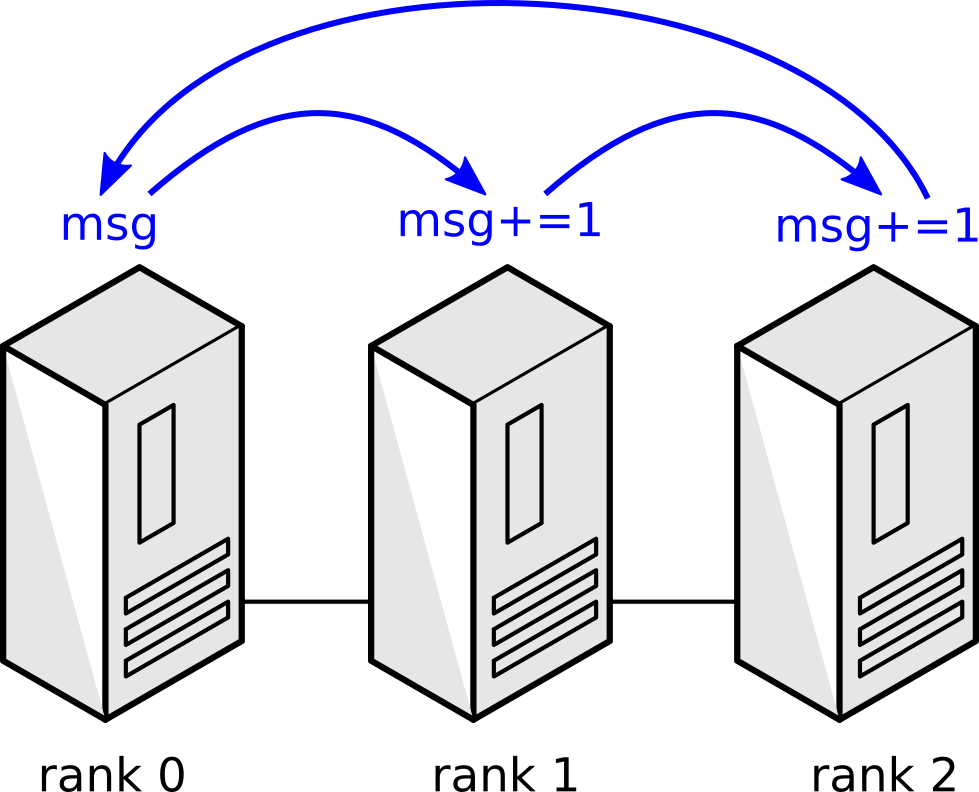
</div>
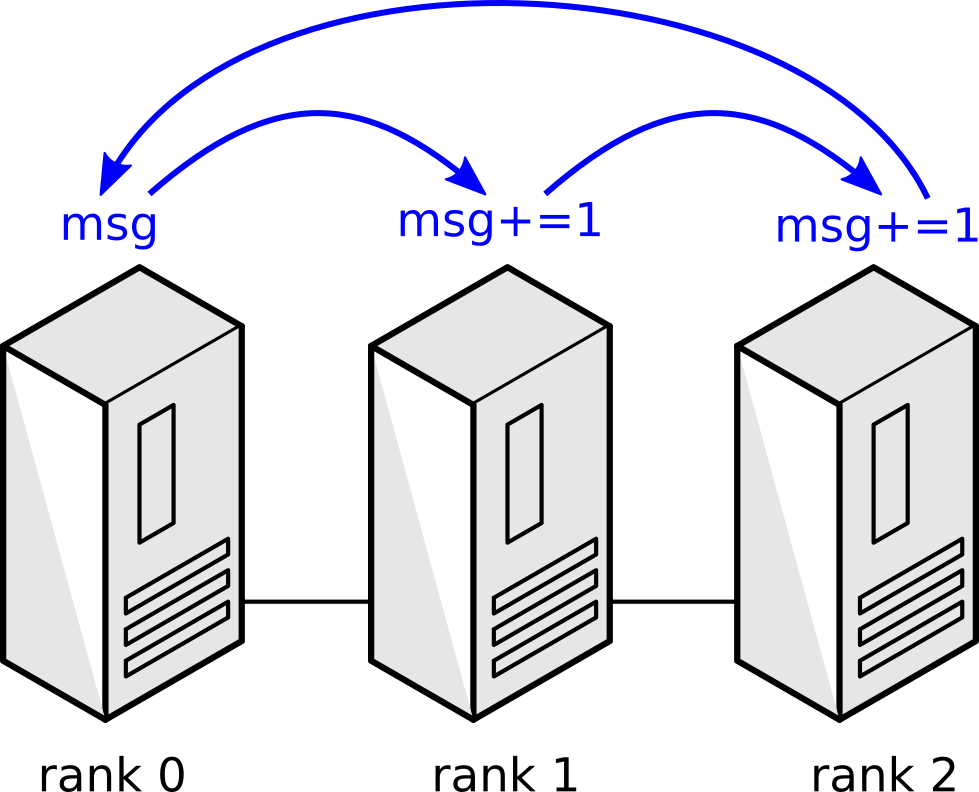

# License

This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.